# STAT 301 Group 19 - Final Project Report

### 1. Introduction

The primary goal of our analysis is to analyze potential predictors to determine the odds of an employee staying or leaving a company, which will be conducted using the Employees dataset.

The Employees dataset is comprised of anonymized information about employees in company, including: highest education level, work history, location, salary, demographics, and information regarding their work with the company. This data was collected by the company Human Resources department and contributed to Kaggle, a community offering data science resources and tools.

#### Overview of variables:
- **Education** *(categorical)*: chr representing the highest level of education attained by the employee.

- **JoiningYear** *(numerical)*: dbl representing the year a given employee first started working for the company.

- **City** *(categorical)*: chr representing the city in which an employee works for the company.

- **PaymentTier** *(categorical)*: dbl representing a bin containing an employee's salary.

- **Age** *(numerical)*: dbl representing the age of employees working at a company.

- **Gender** *(categorical)*: chr representing the sex of employees working at a company.

- **EverBenched** *(binary)*: chr representing whether or not an employee has been benched, ie. had a period of time without work assigned to them.

- **ExperienceInCurrentDomain** *(categorical)*: dbl representing the years of experience an employee has in the area of their role prior to joining the company.

- **LeaveOrNot** *(binary)*: dbl representing whether an employee left of not.

In order to select a model, we'd analyze the relation of these predictors with our response, LeaveOrNot, as well as their relationships with each other to determine the presence of interaction. Once our analysis is complete, we would then train a logistic model using these predictors to predict an employee's odds of leaving using a testing set. A logistic model was selected as our response is a binary variable.

Our data supports this goal by providing information on all of these predictors, however, we will need to transform the data by pre-processing variables and dropping variables we do not wish to include.

**We included the following predictors:**
- **Education, ExperienceinCurrentDomain, and Age** provide information on an employee's prior qualifications prior to starting to work at the company. This  provides a glimpse into the employee's professional background and an approximation of their career stage.

- Prior literature suggests that salary (**PaymentTier**) has a positive relationship with employee retention, hence its inclusion

- **EverBenched** is relevant as if employees went prolonged periods without access to work or other meaningful tasks, they may develop a negative perception of their experience with the company .

- **City** would allow for more generalization as the model could account for specific municipal or location-based factors, including workplace culture

**We excluded the following predictors:**
- Gender: We elected to not include Gender for two reasons. The first is that this isn't inclusive as when the data was collected, Gender was presented as a binary option when in practice, many people identify as genders beyond the binary. This also may introduce a response bias, as participants who identify as a non-binary gender would be required to incorrectly list their gender identity without an option to not disclose this information. Secondly, this may skew information due to differing societal expectations of men and women in the workplace. We do in fact live in a patriarchal society where women starting families are pressured to bear the majority of childcare responsibilities which may impact whether a female employee chooses to leave the company. 

- JoiningYear: We elected to exclude this as we felt that it wouldn't be able to provide much context without other information that we did not have access to. For example, if we wanted to use JoiningYear to determine how long an employee has worked at the company, we would be unable to do so without access to data and information on when an employee left the company (if applicable). This approach is also flawed in that we won’t know how long an employee marked as staying is planning on continuing at the company (ex. There is no difference between an employee leaving in 1 day vs 1 year).


### 2. Methods and Results

#### a. Exploratory Data Analysis

In [26]:
# Attaching packages. Source: Course worksheets
library(plyr)
library(dplyr)
library(tidyverse)
library(cowplot)
library(ggplot2)
library(reshape2)
library(repr)
library(infer)
library(broom)
library(AER)
library(modelr)
library(glmnet)
library(tidymodels)
library(mltools)
library(caret)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ dials        1.2.0     ✔ tune         1.1.2
✔ modeldata    1.2.0     ✔ workflows    1.1.3
✔ parsnip      1.1.1     ✔ workflowsets 1.0.1
✔ recipes      1.0.8     ✔ yardstick    1.2.0
✔ rsample      1.2.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ dplyr::arrange()    masks plyr::arrange()
✖ modelr::bootstrap() masks broom::bootstrap()
✖ purrr::compact()    masks plyr::compact()
✖ dplyr::count()      masks plyr::count()
✖ dplyr::desc()       masks plyr::desc()
✖ scales::discard()   masks purrr::discard()
✖ Matrix::expand()    masks tidyr::expand()
✖ dplyr::failwith()   masks plyr::failwith()
✖ dplyr::filter()     masks stats::filter()
✖ recipes::fixed()    masks stringr::fixed()
✖ dplyr::id()   

In [18]:
employee <- read.csv("data/Employee.csv", header = TRUE)

employee <- employee %>%
    select(-Gender, -JoiningYear)

head(employee)

,Education,City,PaymentTier,Age,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
,<chr>,<chr>,<int>,<int>,<chr>,<int>,<int>
1,Bachelors,Bangalore,3,34,No,0,0
2,Bachelors,Pune,1,28,No,3,1
3,Bachelors,New Delhi,3,38,No,2,0
4,Masters,Bangalore,3,27,No,5,1
5,Masters,Pune,3,24,Yes,2,1
6,Bachelors,Bangalore,3,22,No,0,0


In [19]:
unique(employee$LeaveOrNot) # 2 levels (0, 1)
unique(employee$ExperienceInCurrentDomain) # 8 levels (0 - 7)
unique(employee$EverBenched) #  2 levels ("No" and "Yes")
unique(employee$PaymentTier) # 3 levels (1, 2, and 3)
unique(employee$City) # 3 levels ("Bangalore", "Pune", and "New Delhi")
unique(employee$Education) # 3 levels ("Bachelors", "Masters", and "PHD")

[1] 0 1

[1] 0 3 2 5 1 4 7 6

[1] "No"  "Yes"

[1] 3 1 2

[1] "Bangalore" "Pune"      "New Delhi"

[1] "Bachelors" "Masters"   "PHD"

In [21]:
employee <- employee |>
    mutate(EverBenched = ifelse(EverBenched == "Yes", 1, 0),   # EverBenched into 0 for "No" and 1 for "Yes"
           City = ifelse(City == "Pune", 1,
                        ifelse(City == "New Delhi", 2, 0)),   # "Bangalore" is 0, "Pune" is 1, "New Delhi" is 2
           Education = ifelse(Education == "Masters", 1,
                             ifelse(Education == "PHD", 2, 0)))   # "Bachelors" is 0, "Masters" is 1, "PHD" is 2
head(employee)

,Education,City,PaymentTier,Age,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
,<dbl>,<dbl>,<int>,<int>,<dbl>,<int>,<int>
1,0,0,3,34,0,0,0
2,0,1,1,28,0,3,1
3,0,2,3,38,0,2,0
4,1,0,3,27,0,5,1
5,1,1,3,24,1,2,1
6,0,0,3,22,0,0,0


#### b. Methods and Plan

#### Making a Heatmap!

Using a **heatmap**, we evaluated the correlation of all our predictors with response and each other. We then used the results of our heatmap to guide whether we include or exclude a predictor in our analysis. 

In [23]:
corr_matrix_employee <- 
   employee %>%
   cor() %>%
   as_tibble(rownames = 'var1') %>%
   pivot_longer(-var1, names_to = "var2", values_to = "corr")

head(corr_matrix_employee)

var1,var2,corr
<chr>,<chr>,<dbl>
Education,Education,1.000000000
Education,City,0.390889582
Education,PaymentTier,-0.140741037
Education,Age,-0.010611066
Education,EverBenched,-0.052248638
Education,ExperienceInCurrentDomain,-0.004462647


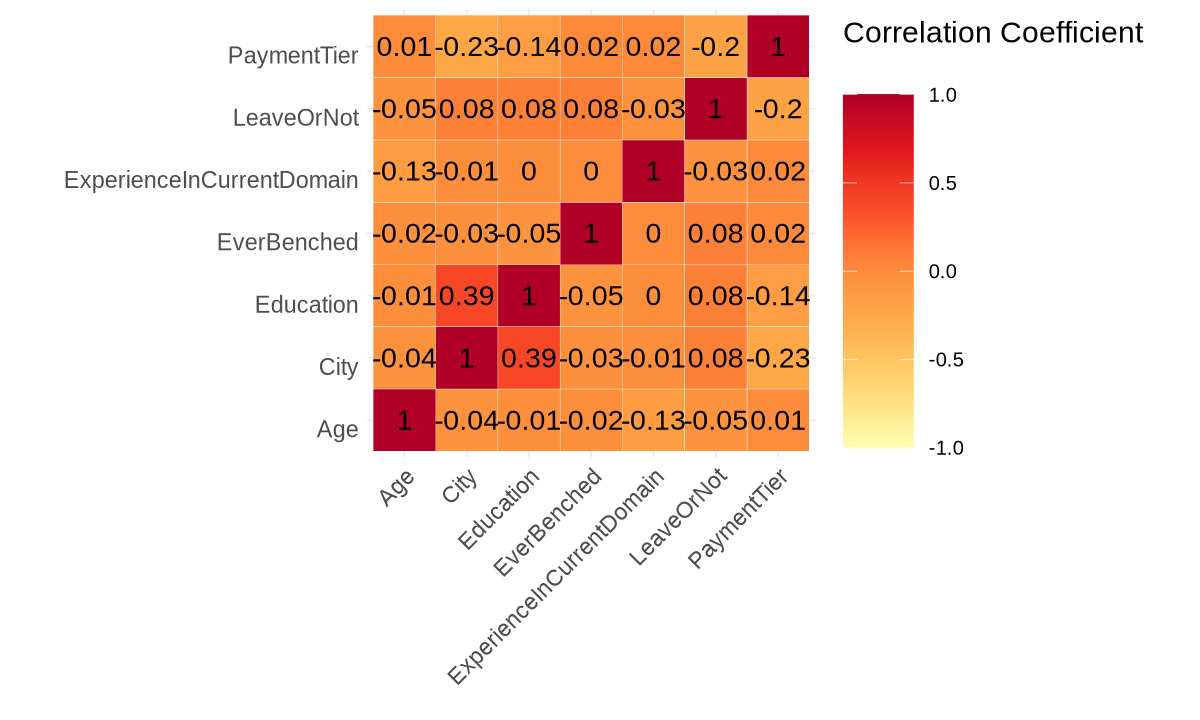

In [24]:
options(repr.plot.width = 10, repr.plot.height = 6) 

employee_processed_plot <- 
  corr_matrix_employee %>%
  ggplot(aes(var1, var2)) +
  geom_tile(aes(fill = corr), color = "white") +
  scale_fill_distiller("Correlation Coefficient \n",
      palette =  "YlOrRd",
      direction = 1, 
      limits = c(-1, 1)
    ) +
    labs(x = "", y = "") +
    theme_minimal() +
    theme(
        axis.text.x = element_text(angle = 45, vjust = 1, size = 14, hjust = 1),
        axis.text.y = element_text(vjust = 1, size = 14, hjust = 1),
        legend.title = element_text(size = 18),
        legend.text = element_text(size = 12),
        legend.key.size = unit(1.5, "cm")
    ) +
    coord_fixed() + geom_text(aes(var1, var2, label = round(corr, 2)), color = "black", size = 6)

employee_processed_plot

#### Interpreting the Heatmap:

Based on the results of our heatmap, none of our predictors are highly correlated with each other (corr ranges from -0.14 to 0.39). This suggests that our predictors don't interact with each other very much. This suggests that an additive model would be appropriate given the lack of interaction between predictors. 

Additionally, our predictors (when considered individually) aren't very correlated with our response, LeaveOrNot (corr ranges from -0.05 to 0.2). When considered together, it may be possible to develop a more reliable model. As such, we elected to not exclude any predictors.



To approach our question, we will conduct **logistic regression** as our response is a binary variable. This will be fit for a **predictive model**. However, there are a few key steps we need to take before conducting any tests. 

As seen from the EDA and Correlation Heatmap above, we have a wide selection of predictors to select from. We intend to use these predictors in order to explain our overarching question about employee retention, but a challenging obstacle is presented beforehand: how can we improve our prediction accuracy, and what can we do in order to increase model interpretibility? There may be variables that aren't relevant to our analysis, and including them would only increase variance. Let us constrain our project to only variables that are deemed relevant to our topic. To do so, we will split our dataset and perform **LASSO Regularization** to shrink our model before performing regression. This is our **Feature Selection**, and will be shown below. Afterwards, we will test our model and further discuss the findings.

## Feature Selection:

Throughout this section, we will be discussing how and why we chose our covariates. The goal for our LASSO regularization is to find the optimum number of predictors that produces the highest average AUC. In doing so, the lasso method is able to reduce the number of predictors we will use in our model by shrinking their coefficients to zero during optimization, which will help improve our models interpretibility. Furthermore, this will hopefully coincide with our correlation heatmap from above and we will approach this in our discussion. 

Cross-fold validation can be used initially to select the number of parameters as it reduces the risk of overfitting, tunes the parameters and selects the ones that generalizes well to new data, and reduces variability.

Now we will split our data into training and testing, and prepare the training data for LASSO. We will do this at a 60/40 ratio for predictive purposes. Note that we are dropping `Gender` and `JoiningYear` as per the reasons in the intro.

LASSO uses the `glmnet` function which only works on model matrixes, so we will use `model.matrix` to prepare our data. We will also remove the (Intercept) column, which is filled with ones and not relevant to our preparation.

In [35]:
# Main Developer: Andy Hong

set.seed(1234)

## load data
employee  <- read.csv("data/Employee.csv")

## split into training and testing
split <- initial_split(employee, prop = 0.6) 

employee_training <- training(split) %>%
    select(-Gender, -JoiningYear)
employee_testing <- testing(split) %>%
    select(-Gender, -JoiningYear)

model_matrix_X_train <- 
    model.matrix(LeaveOrNot ~ ., employee_training)[,-1]

matrix_Y_train <- 
    as.matrix(employee_training$LeaveOrNot, ncol = 1)

With our prepared training data, we can use `cv.glmnet` to find the optimal $\lambda$ value that provides the largest average AUC. 

We will use 5-fold cross validation for this model.

In [36]:
# Main Developer: Andy Hong

set.seed(1234)

employee_cv_lambda_LASSO <- 
  cv.glmnet(
  x = model_matrix_X_train, y = matrix_Y_train,
  alpha = 1,
  family = 'binomial',
  type.measure = 'auc',
  nfolds = 5)

employee_cv_lambda_LASSO


Call:  cv.glmnet(x = model_matrix_X_train, y = matrix_Y_train, type.measure = "auc",      nfolds = 5, alpha = 1, family = "binomial") 

Measure: AUC 

     Lambda Index Measure       SE Nonzero
min 0.00371    37  0.6959 0.008299       7
1se 0.01364    23  0.6876 0.006949       6

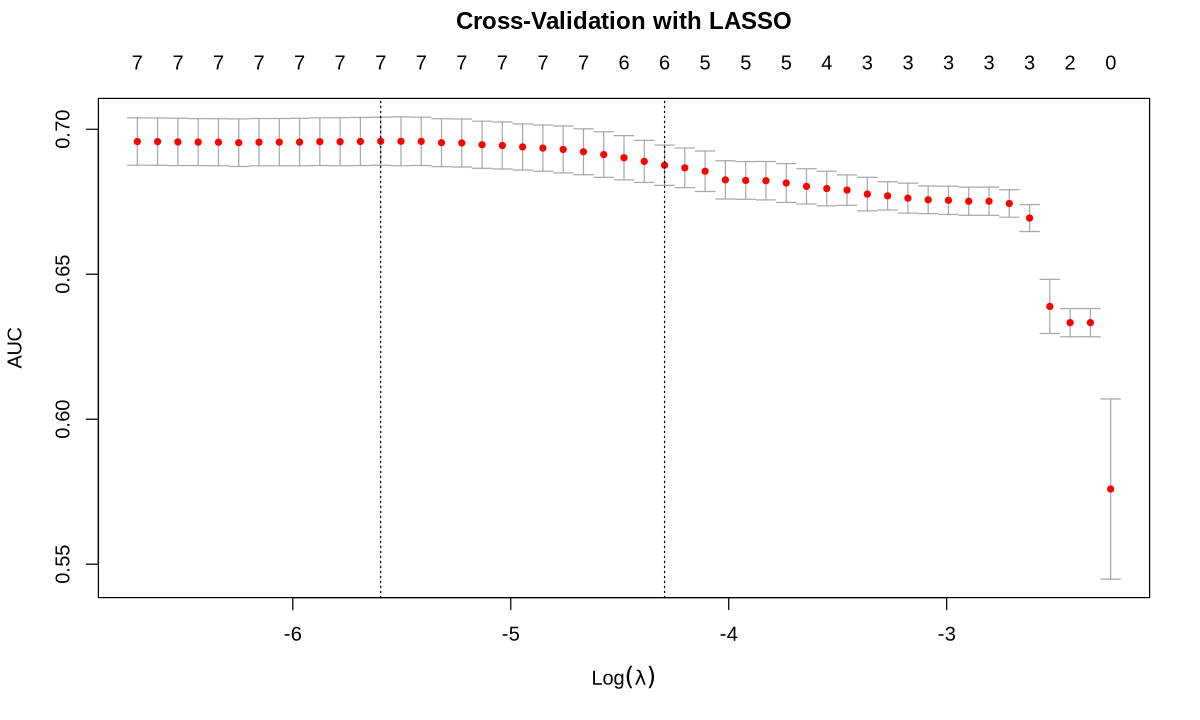

In [37]:
# Main Developer: Andy Hong

set.seed(1234)

options(repr.plot.width = 10, repr.plot.height = 6)

plot(employee_cv_lambda_LASSO, main = "Cross-Validation with LASSO\n\n")

The two vertical liness from `cv.glmnet()` correspond to two values of $\lambda$:

- $\hat{\lambda}_{\text{min}}$ which provides the maximum average AUC out of the whole sequence for $\lambda$.


- $\hat{\lambda}_{\text{1SE}}$ is the highest $\lambda$ for which the model has an average AUC within one standard error of the maximum.

The numbers across the top of the graph indicate the number of predictors (value of $\lambda$) used. For our case, we will use $\hat{\lambda}_{\text{1SE}}$, as our goal is to improve model interpretibility and the most important set of predictors is more useful for feature selection.

We will extract this value of $\lambda$.

In [38]:
# Main Developer: Andy Hong

set.seed(1234)

employee_cv_lambda1se_LASSO_value <- round(employee_cv_lambda_LASSO$lambda.1se, 4)
employee_cv_lambda1se_LASSO_value

[1] 0.0136

Now we can use this value for LASSO to determine which predictors to select using `glmnet`.

In [39]:
# Main Developer: Andy Hong

set.seed(1234)

employee_LASSO <- glmnet(
x = model_matrix_X_train, y = matrix_Y_train,
  alpha = 1,
  family = 'binomial',
  lambda = employee_cv_lambda1se_LASSO_value
)

coef(employee_LASSO)

9 x 1 sparse Matrix of class "dgCMatrix"
                                   s0
(Intercept)                0.67284687
EducationMasters           0.63264212
EducationPHD               .         
CityNew Delhi             -0.03687988
CityPune                   0.72083728
PaymentTier               -0.50340855
Age                       -0.01095366
EverBenchedYes             0.30887762
ExperienceInCurrentDomain  .         

Interesting! We are given `EducationMasters`, `CityNew Delhi`, `CityPune`, `PaymentTier`, `Age`,  and `EverBenchedYes` as our parameters. It seems that LASSO chose subsets of our variables (`EverBenchedYes` rather than just `EverBenched`) for our predictors. 

For simplicity and once again, model interpretability, we will use the base predictors `Education`, `PaymentTier`, `City`, `Age`, and `EverBenched`. 

## Testing the Model

Our last step is to test our model. To do this, we will create our **logistic model** based off the covariates found above fit off the training data. Then, we will use the trained model to predict the testing data, and we will display this using a confusion matrix.

In [40]:
# Main Developer: Andy Hong

set.seed(1234)

employee_logistic_model <- glm(LeaveOrNot ~ Education + City + PaymentTier + Age + EverBenched, 
                               data = employee_training, family = 'binomial')

employee_pred_class <- round(predict(employee_logistic_model, newdata = employee_testing, type = 'response'))

employee_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(employee_pred_class),
    reference = as.factor(employee_testing$LeaveOrNot),
    positive = '1'
)
employee_confusion_matrix

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1063  416
         1  167  216
                                          
               Accuracy : 0.6869          
                 95% CI : (0.6653, 0.7079)
    No Information Rate : 0.6606          
    P-Value [Acc > NIR] : 0.008504        
                                          
                  Kappa : 0.2278          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.3418          
            Specificity : 0.8642          
         Pos Pred Value : 0.5640          
         Neg Pred Value : 0.7187          
             Prevalence : 0.3394          
         Detection Rate : 0.1160          
   Detection Prevalence : 0.2057          
      Balanced Accuracy : 0.6030          
                                          
       'Positive' Class : 1               
                        

This confusion matrix tells us key information. Let us detail the numbers first. We ended up with an accuracy level of 68.89%. This is the percentage of correct predictions that our model (which was trained on `employee_training`) made against the `employee_testing` data, which are new, unseen observations. Sensitivity is the True Positive Rate, which is the number of correct positive predictions divided by all the positive predictions. We had a sensitivity of 0.3418, when the desirable rate would be closer to 1. Cohen's Kappa is seen at 0.2278, which describes how often the predictions and actual classification coincide just by chance. Kappa is also desired to be closer to 1, so what does this mean? 

As a model assessment, we can say that predicting employee retention based off of these covariates will achieve an accurate result around 68.89% of the time. Of course, we wished to achieve a higher accuracy, but changing the model now would entail overfitting and bias. Let's look at how the testing data was collected: the employee data set was anonymized in different demographics, and was found on a public domain. Furthermore, there is mainly quantitative data collected, with no information on workplace conditions or culture. Therefore it is possible that a better our model is missing key data that is needed for accurate prediction. Lastly, we can look at our p-value. The p-value in the confusion matrix uses a one-sided test if the accuracy is better than having no information (NIR = No Information Rate). At a significance level of 0.05, our p-value of 0.008504 is less than 0.05, which indicates our results are not just by chance but are statistically significant. Therefore our model is alright for what we were given. 

### 3. Discussion

### 4. References